In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import PIL
from PIL import Image
from skimage.transform import resize, rescale

Using TensorFlow backend.


In [4]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    # todo
    
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)
    
    position = ds.PatientPosition
    body_part = ds.BodyPartExamined
    image_type = ds.Modality
    result = ds.StudyDescription
    
    print('This is a %s image of the %s taken from a %s position for which the result was: %s'%(image_type, body_part, position, result))
    
    
    if body_part=='CHEST' and image_type=='DX':
        if position == 'AP' or position=='PA': 
            print('Image matches required criteria :)')
            img = ds.pixel_array

            print('Displaying Image:')

            plt.imshow(img, interpolation='nearest')
            plt.show()
        else:
            print('Image does not match required criteria')
            img = None
 
    else:
        print('Image does not match required criteria')
        img = None
    
    
    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size): 
    # todo
    #proc_img = (img - img_mean)/img_std
    #proc_img =  resize(proc_img, img_size, anti_aliasing=True)
    
    # Try rescaling image
    #proc_img = ImageDataGenerator(rescale=1. / 255.0)
    proc_img = rescale(img, 1./255.0, anti_aliasing=False)
    proc_img =  resize(proc_img, img_size, anti_aliasing=True)
    
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    # todo
    with open(model_path, 'r') as json_file:
        saved_model = json_file.read()
        
    model = tf.keras.models.model_from_json(saved_model)
    model.summary()
    
    model.load_weights(weight_path)
    
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    # todo 
    
    pred = model.predict(img)
    print(pred)
    prediction = (pred > thresh)
    
    return prediction 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

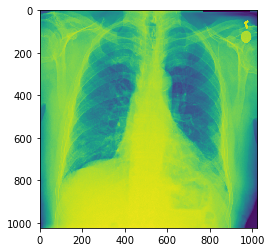

[[0.5459321]]
Pneumonia Prediction: True
--------------------------------------------------------------

Load file test2.dcm ...
This is a DX image of the CHEST taken from a AP position for which the result was: Cardiomegaly
Image matches required criteria :)
Displaying Image:


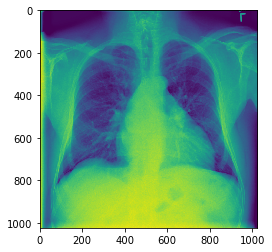

[[0.5447087]]
Pneumonia Prediction: True
--------------------------------------------------------------

Load file test3.dcm ...
This is a DX image of the CHEST taken from a AP position for which the result was: Effusion
Image matches required criteria :)
Displaying Image:


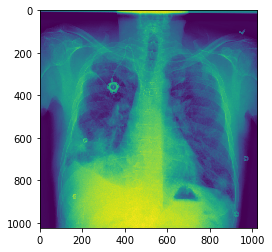

[[0.5455544]]
Pneumonia Prediction: True
--------------------------------------------------------------

Load file test4.dcm ...
This is a DX image of the RIBCAGE taken from a PA position for which the result was: No Finding
Image does not match required criteria
Load file test5.dcm ...
This is a CT image of the CHEST taken from a PA position for which the result was: No Finding
Image does not match required criteria
Load file test6.dcm ...
This is a DX image of the CHEST taken from a XX position for which the result was: No Finding
Image does not match required criteria


In [5]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'my_model_2.json' #path to saved model
weight_path = 'xray_class_my_model.best.hdf5' #path to saved best weights

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
#img_mean = np.mean(img) # loads the mean image value they used during training preprocessing
#img_std = np.mean(std) # loads the std dev image value they used during training preprocessing

my_model = load_model(model_path, weight_path) #loads model
thresh = 0.45 #loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,np.mean(img),np.std(img),IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print('Pneumonia Prediction: '+str(pred[0][0]))
    print('--------------------------------------------------------------')
    print()